In [ ]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf


In [4]:
hit_data_scope_1081 = sf.DUT_TELE_merge(1081)

In [2]:
scope_data_1088=sf.DUT_TELE_merge(1088)

In [6]:
# hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)
hit_data_scope_1093 = sf.DUT_TELE_merge(1093)

In [3]:
# gal_scope_1081 = sf.gal_scope_merge(1081)

DataFrames constructed.
DataFrames grouped by TLU/triggerid
DataFrames merged
collected garbage


In [6]:
hit_data_1081 = rf.get_ROOT_data_zip_RECO(1081)

1081 RECONSTRUCTED finished


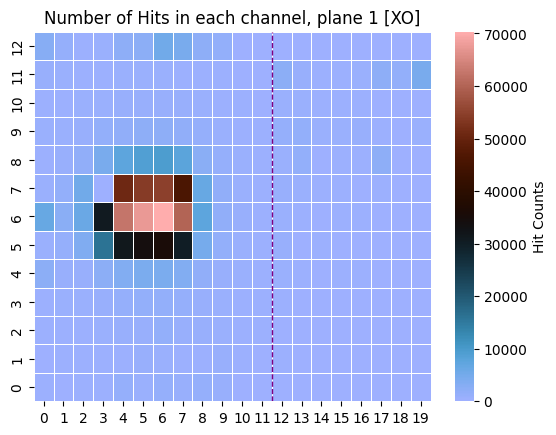

In [15]:
rf.hits_amount_colormap_single_plane(hit_data_scope_1093.hits,1)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

PAD RECONSTRUCTION - Neuron Network

In [ ]:
# build a function for neuron model training

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim


In [30]:
# get the input parameters as arrays
pad = 125
plane = 3
hit_data = hit_data_scope_1093
N = len(hit_data)


# x,y
initial_x = hit_data_scope_1093.tele.x
initial_y = hit_data_scope_1093.tele.y

# previous plane
previous_plane = hit_data.hits[hit_data.hits.plane == plane - 1]
prev_plane_same_ch = previous_plane[previous_plane.ch == pad]
prev_plane_amp = ak.where(ak.num(prev_plane_same_ch.amp) != 1, [[0]], prev_plane_same_ch.amp)

# next plane
next_plane = hit_data.hits[hit_data.hits.plane == plane + 1]
next_plane_same_ch = next_plane[next_plane.ch == pad]
next_plane_amp = ak.where(ak.num(next_plane_same_ch.amp) != 1, [[0]], next_plane_same_ch.amp)

# plane
pad_z = np.full(N,plane)


# output = amplitude of the wanted pad
plane_data = hit_data.hits[hit_data.hits.plane == plane]
plane_pad_data = plane_data[plane_data.ch == pad]
current_pad_amp = ak.where(ak.num(next_plane_same_ch.amp) != 1, [[0]], next_plane_same_ch.amp)


In [34]:
initial_x_np = ak.to_numpy(initial_x).astype(np.float32)
initial_y_np = ak.to_numpy(initial_y).astype(np.float32)
pad_z_np = ak.to_numpy(pad_z).astype(np.float32)
prev_amp_np = ak.to_numpy(prev_plane_amp).astype(np.float32)
next_amp_np = ak.to_numpy(next_plane_amp).astype(np.float32)

y_np = ak.to_numpy(current_pad_amp).astype(np.float32)

X = np.column_stack([initial_x_np, initial_y_np, pad_z_np, prev_amp_np, next_amp_np]).astype(np.float32)
y = y_np.reshape(-1, 1).astype(np.float32)

X_t = torch.from_numpy(X)
y_t = torch.from_numpy(y)

print(X_t.shape, y_t.shape)

torch.Size([440902, 5]) torch.Size([440902, 1])


In [39]:
print(torch.isnan(X_t).any(), torch.isinf(X_t).any())
print(torch.isnan(y_t).any(), torch.isinf(y_t).any())


tensor(False) tensor(False)
tensor(False) tensor(False)


In [40]:
y_mean = y_t.mean()
baseline_mse = ((y_t - y_mean) ** 2).mean()
print("Baseline MSE:", float(baseline_mse))


Baseline MSE: 34670.609375


In [ ]:
# normalize the values in X_t for balanced calculations
X_mean = X_t.mean(dim=0, keepdim=True)
X_std  = X_t.std(dim=0, keepdim=True) + 1e-8
X_tn   = (X_t - X_mean) / X_std


torch.Size([440902, 5])

In [ ]:
dataset = TensorDataset(X_tn, y_t)

N = len(dataset)
train_size = int(0.8 * N)
val_size = N - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1024, shuffle=False)

In [ ]:
# define the neuron model (5 inputs to 1 output)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

model = Net()


In [ ]:
# loss function and optimization
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
# evaluation helper
def eval_loss(model, loader):
    model.eval()
    total = 0.0
    count = 0
    with torch.no_grad():
        for xb, yb in loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total += loss.item() * xb.size(0)
            count += xb.size(0)
    return total / count


In [ ]:
# training loop
epochs = 10  # start small; increase later

for epoch in range(1, epochs + 1):
    model.train()
    total = 0.0
    count = 0

    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item() * xb.size(0)
        count += xb.size(0)

    train_mse = total / count
    val_mse = eval_loss(model, val_loader)

    print(f"Epoch {epoch:02d} | train MSE: {train_mse:.6f} | val MSE: {val_mse:.6f}")


In [ ]:
# use to predict
model.eval()
with torch.no_grad():
    # example: take the first sample
    pred0 = model(X_tn[0:1])
    print("pred:", float(pred0[0, 0]), "true:", float(y_t[0, 0]))


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

GAP 1081

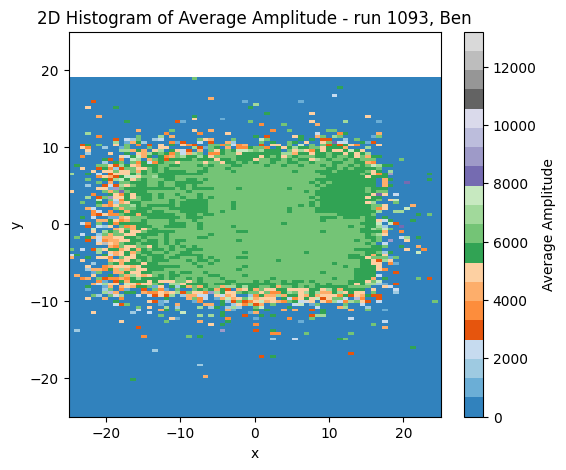

In [4]:
sf.avg_energy_scope_colormap(a, x_borders=25, y_borders=25)

In [5]:
path = "TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco_diagnostics.root"
scope_data_1088_corrected = rf.reconstruct_data_all_dead_pads(scope_data_1088, 5, path)

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\bents\AppData\Local\Temp\ipykernel_24644\2696076564.py:1: SyntaxWarning: invalid escape sequence '\T'
  path = "TB_FIRE\TB_reco\TB_FIRE_1088_raw_reco_diagnostics.root"


shower center: 112
we got the data
amount of dead channels: 140
{plane_ID: 1, channel_ID: 77}
48 channels left
{plane_ID: 1, channel_ID: 133}
47 channels left
{plane_ID: 2, channel_ID: 32}
46 channels left
{plane_ID: 2, channel_ID: 50}
45 channels left
{plane_ID: 2, channel_ID: 54}
44 channels left
{plane_ID: 2, channel_ID: 67}
43 channels left
{plane_ID: 2, channel_ID: 77}
42 channels left
{plane_ID: 2, channel_ID: 148}
41 channels left
{plane_ID: 2, channel_ID: 172}
40 channels left
{plane_ID: 2, channel_ID: 173}
39 channels left
{plane_ID: 2, channel_ID: 174}
38 channels left
{plane_ID: 2, channel_ID: 175}
37 channels left
{plane_ID: 2, channel_ID: 176}
36 channels left
{plane_ID: 2, channel_ID: 177}
35 channels left
{plane_ID: 2, channel_ID: 192}
34 channels left
{plane_ID: 2, channel_ID: 193}
33 channels left
{plane_ID: 2, channel_ID: 195}
32 channels left
{plane_ID: 2, channel_ID: 212}
31 channels left
{plane_ID: 2, channel_ID: 213}
30 channels left
{plane_ID: 2, channel_ID: 217}